In [1]:
import numpy as mp
import matplotlib.pyplot as plt
import time
import numba
import random
from load_mnist import *
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape
shuffle_index = np.random.permutation(60000)
X_train, Y_train = X_train[shuffle_index],Y_train[shuffle_index]
label = []
for i in range(len(Y_train)):
    label.append(Y_train[i].argmax())
    
label = np.array(label).reshape(60000,)

label_t = []
for i in range(len(Y_test)):
    label_t.append(Y_test[i].argmax())
    
label_t = np.array(label_t).reshape(10000,)

In [2]:
class AffineComponent:
    def __init__(self,input_dim,output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.weights = 0.01 * np.random.randn(input_dim, output_dim)
        self.bias = 0.01 * np.random.randn(1,output_dim)

    def propagate(self,input_data):
        assert input_data.shape[1] == self.input_dim
        self.input_data = input_data
        return input_data @ self.weights + self.bias

    def back_propagate(self,derivative):
        assert derivative.shape[1] == self.output_dim
        propagate_derivative = derivative @ self.weights.T
        self.__update(derivative)
        return propagate_derivative

    def __update(self,derivative):
        self.bias -= learning_rate * derivative.sum(axis = 0, keepdims= True )
        self.weights -= learning_rate * (self.input_data.T @ derivative)


class NolinearComponent:
    def __init__(self,dim,nolinear_type):
        self.dim = dim
        self.nolinear_type = nolinear_type

    def propagate(self,input_data):
        assert input_data.shape[1] == self.dim
        self.input_data = input_data
        if(self.nolinear_type == "relu"):
            return self.__relu(input_data)
        else:
            assert false

    def __relu(self,input_data):
        output_data = input_data.copy()
        output_data[output_data < 0] = 0
        return output_data

    def back_propagate(self,derivative):
        assert derivative.shape[1] == self.dim
        if(self.nolinear_type == "relu"):
            return self.__back_relu(derivative)
        else:
            assert false
            
    def __back_relu(self,derivative):
        derivative[self.input_data < 0] = 0
        return derivative


class SoftmaxOutputComponent:
    def __init__(self,dim):
        self.dim = dim

    def propagate(self,input_data):
        assert input_data.shape[1] == self.dim
        self.input_data = input_data
        e_x = np.exp(input_data)
        return e_x / e_x.sum(axis=1, keepdims=True)

    def back_propagate(self,probs,label):
        assert probs.shape[0] == label.shape[0]
        batch_size = probs.shape[0]
        delta = probs
        delta[range(batch_size),batch_label] -= 1
        return delta / batch_size

In [14]:
dnn1_affine = AffineComponent(784,128)
dnn1_relu = NolinearComponent(128,"relu")
dnn2_affine = AffineComponent(128,10)
output = SoftmaxOutputComponent(10)

def network_propagate(input_data):
    activate = dnn1_affine.propagate(input_data)
    activate = dnn1_relu.propagate(activate)
    activate = dnn2_affine.propagate(activate)
    return output.propagate(activate)

def network_backpropagate(probs,batch_label):
    derivative = output.back_propagate(probs,batch_label)
    derivative = dnn2_affine.back_propagate(derivative)
    derivative = dnn1_relu.back_propagate(derivative)
    derivative = dnn1_affine.back_propagate(derivative)

def caculate_loss(probs,batch_label):
    batch_size = probs.shape[0]
    loss_list = -np.log(probs[range(batch_size), batch_label])
    average_loss = loss_list.mean(axis=0)
    return average_loss

In [10]:
def score(batch_data, batch_label):
    probs = network_propagate(batch_data)
    prediction = probs.argmax(axis = 1).reshape(batch_label.shape[0],1)
    correct_num = np.sum(batch_label == prediction.T)
    loss = caculate_loss(probs, batch_label)
    
    return float(correct_num) / batch_label.shape[0], loss

In [15]:
score_train = []
loss_train = []
score_test = []
loss_test = []

batch_size = 1000
epochs_num = 40
batches_X = np.array([X_train[i:i+batch_size] for i in range(0, X_train.shape[0], batch_size)])
batches_Y = np.array([label[i:i+batch_size] for i in range(0, Y_train.shape[0], batch_size)])
batches_num = batches_X.shape[0]
for epoch in range(epochs_num):
    for i in range(batches_num):
        learning_rate = 1
        batch_data, batch_label = batches_X[i], batches_Y[i]
        probs = network_propagate(batch_data)
        network_backpropagate(probs, batch_label)
        result_train = score(X_train, label)
        score_train.append(result_train[0])
        loss_train.append(result_train[1])    
        result_test = score(X_test, label_t)
        score_test.append(result_test[0])
        loss_test.append(result_test[1])
        print("(",len(score_train),")","scr_trn:", format(result_train[0],'.4f'), "ls_trn:", format(result_train[1],'.4f'), "scr_tst:", format(result_test[0],'.4f'), "ls_tst:", format(result_test[1],'.4f'),)

( 1 ) scr_trn: 0.2204 ls_trn: 2.2925 scr_tst: 0.2186 ls_tst: 2.2923
( 2 ) scr_trn: 0.2611 ls_trn: 2.2757 scr_tst: 0.2628 ls_tst: 2.2753
( 3 ) scr_trn: 0.2006 ls_trn: 2.2434 scr_tst: 0.2030 ls_tst: 2.2425
( 4 ) scr_trn: 0.2367 ls_trn: 2.1844 scr_tst: 0.2446 ls_tst: 2.1823
( 5 ) scr_trn: 0.3880 ls_trn: 2.0893 scr_tst: 0.4026 ls_tst: 2.0852
( 6 ) scr_trn: 0.4700 ls_trn: 1.9462 scr_tst: 0.4773 ls_tst: 1.9408
( 7 ) scr_trn: 0.5090 ls_trn: 1.8018 scr_tst: 0.5136 ls_tst: 1.7903
( 8 ) scr_trn: 0.4263 ls_trn: 1.6659 scr_tst: 0.4307 ls_tst: 1.6621
( 9 ) scr_trn: 0.3251 ls_trn: 2.2664 scr_tst: 0.3280 ls_tst: 2.2525
( 10 ) scr_trn: 0.3396 ls_trn: 1.9284 scr_tst: 0.3364 ls_tst: 1.9284
( 11 ) scr_trn: 0.4189 ls_trn: 1.6980 scr_tst: 0.4202 ls_tst: 1.6962
( 12 ) scr_trn: 0.5039 ls_trn: 1.4045 scr_tst: 0.5046 ls_tst: 1.3902
( 13 ) scr_trn: 0.5830 ls_trn: 1.2150 scr_tst: 0.5802 ls_tst: 1.2104
( 14 ) scr_trn: 0.3945 ls_trn: 1.6194 scr_tst: 0.3929 ls_tst: 1.6132
( 15 ) scr_trn: 0.4196 ls_trn: 2.0132 scr_t

( 120 ) scr_trn: 0.8874 ls_trn: 0.3398 scr_tst: 0.8866 ls_tst: 0.3328
( 121 ) scr_trn: 0.8680 ls_trn: 0.3851 scr_tst: 0.8669 ls_tst: 0.3866
( 122 ) scr_trn: 0.9082 ls_trn: 0.2907 scr_tst: 0.9088 ls_tst: 0.2787
( 123 ) scr_trn: 0.9299 ls_trn: 0.2418 scr_tst: 0.9296 ls_tst: 0.2337
( 124 ) scr_trn: 0.9297 ls_trn: 0.2388 scr_tst: 0.9313 ls_tst: 0.2274
( 125 ) scr_trn: 0.9315 ls_trn: 0.2359 scr_tst: 0.9332 ls_tst: 0.2245
( 126 ) scr_trn: 0.9316 ls_trn: 0.2348 scr_tst: 0.9320 ls_tst: 0.2259
( 127 ) scr_trn: 0.9308 ls_trn: 0.2334 scr_tst: 0.9303 ls_tst: 0.2230
( 128 ) scr_trn: 0.9318 ls_trn: 0.2346 scr_tst: 0.9317 ls_tst: 0.2249
( 129 ) scr_trn: 0.9292 ls_trn: 0.2381 scr_tst: 0.9287 ls_tst: 0.2285
( 130 ) scr_trn: 0.9334 ls_trn: 0.2272 scr_tst: 0.9315 ls_tst: 0.2186
( 131 ) scr_trn: 0.9260 ls_trn: 0.2459 scr_tst: 0.9271 ls_tst: 0.2406
( 132 ) scr_trn: 0.9244 ls_trn: 0.2516 scr_tst: 0.9241 ls_tst: 0.2421
( 133 ) scr_trn: 0.9321 ls_trn: 0.2297 scr_tst: 0.9334 ls_tst: 0.2187
( 134 ) scr_trn: 0.9

( 238 ) scr_trn: 0.9517 ls_trn: 0.1661 scr_tst: 0.9492 ls_tst: 0.1652
( 239 ) scr_trn: 0.9510 ls_trn: 0.1656 scr_tst: 0.9492 ls_tst: 0.1647
( 240 ) scr_trn: 0.9519 ls_trn: 0.1626 scr_tst: 0.9491 ls_tst: 0.1621
( 241 ) scr_trn: 0.9495 ls_trn: 0.1693 scr_tst: 0.9472 ls_tst: 0.1702
( 242 ) scr_trn: 0.9477 ls_trn: 0.1746 scr_tst: 0.9455 ls_tst: 0.1735
( 243 ) scr_trn: 0.9503 ls_trn: 0.1677 scr_tst: 0.9479 ls_tst: 0.1676
( 244 ) scr_trn: 0.9502 ls_trn: 0.1678 scr_tst: 0.9472 ls_tst: 0.1666
( 245 ) scr_trn: 0.9527 ls_trn: 0.1624 scr_tst: 0.9519 ls_tst: 0.1607
( 246 ) scr_trn: 0.9537 ls_trn: 0.1593 scr_tst: 0.9515 ls_tst: 0.1594
( 247 ) scr_trn: 0.9526 ls_trn: 0.1602 scr_tst: 0.9512 ls_tst: 0.1587
( 248 ) scr_trn: 0.9524 ls_trn: 0.1627 scr_tst: 0.9508 ls_tst: 0.1622
( 249 ) scr_trn: 0.9499 ls_trn: 0.1702 scr_tst: 0.9469 ls_tst: 0.1688
( 250 ) scr_trn: 0.9532 ls_trn: 0.1596 scr_tst: 0.9499 ls_tst: 0.1593
( 251 ) scr_trn: 0.9474 ls_trn: 0.1770 scr_tst: 0.9425 ls_tst: 0.1808
( 252 ) scr_trn: 0.9

( 356 ) scr_trn: 0.9613 ls_trn: 0.1312 scr_tst: 0.9579 ls_tst: 0.1379
( 357 ) scr_trn: 0.9617 ls_trn: 0.1300 scr_tst: 0.9599 ls_tst: 0.1362
( 358 ) scr_trn: 0.9632 ls_trn: 0.1277 scr_tst: 0.9602 ls_tst: 0.1321
( 359 ) scr_trn: 0.9620 ls_trn: 0.1299 scr_tst: 0.9581 ls_tst: 0.1354
( 360 ) scr_trn: 0.9631 ls_trn: 0.1274 scr_tst: 0.9587 ls_tst: 0.1327
( 361 ) scr_trn: 0.9597 ls_trn: 0.1345 scr_tst: 0.9578 ls_tst: 0.1417
( 362 ) scr_trn: 0.9606 ls_trn: 0.1336 scr_tst: 0.9569 ls_tst: 0.1380
( 363 ) scr_trn: 0.9618 ls_trn: 0.1302 scr_tst: 0.9584 ls_tst: 0.1355
( 364 ) scr_trn: 0.9625 ls_trn: 0.1289 scr_tst: 0.9587 ls_tst: 0.1332
( 365 ) scr_trn: 0.9625 ls_trn: 0.1305 scr_tst: 0.9600 ls_tst: 0.1345
( 366 ) scr_trn: 0.9630 ls_trn: 0.1275 scr_tst: 0.9595 ls_tst: 0.1341
( 367 ) scr_trn: 0.9636 ls_trn: 0.1259 scr_tst: 0.9613 ls_tst: 0.1306
( 368 ) scr_trn: 0.9636 ls_trn: 0.1270 scr_tst: 0.9594 ls_tst: 0.1328
( 369 ) scr_trn: 0.9601 ls_trn: 0.1364 scr_tst: 0.9554 ls_tst: 0.1410
( 370 ) scr_trn: 0.9

( 474 ) scr_trn: 0.9696 ls_trn: 0.1063 scr_tst: 0.9659 ls_tst: 0.1159
( 475 ) scr_trn: 0.9699 ls_trn: 0.1048 scr_tst: 0.9659 ls_tst: 0.1157
( 476 ) scr_trn: 0.9684 ls_trn: 0.1078 scr_tst: 0.9637 ls_tst: 0.1194
( 477 ) scr_trn: 0.9690 ls_trn: 0.1065 scr_tst: 0.9647 ls_tst: 0.1181
( 478 ) scr_trn: 0.9697 ls_trn: 0.1047 scr_tst: 0.9655 ls_tst: 0.1144
( 479 ) scr_trn: 0.9688 ls_trn: 0.1075 scr_tst: 0.9642 ls_tst: 0.1184
( 480 ) scr_trn: 0.9695 ls_trn: 0.1053 scr_tst: 0.9649 ls_tst: 0.1159
( 481 ) scr_trn: 0.9675 ls_trn: 0.1092 scr_tst: 0.9651 ls_tst: 0.1216
( 482 ) scr_trn: 0.9688 ls_trn: 0.1065 scr_tst: 0.9642 ls_tst: 0.1161
( 483 ) scr_trn: 0.9689 ls_trn: 0.1074 scr_tst: 0.9643 ls_tst: 0.1179
( 484 ) scr_trn: 0.9694 ls_trn: 0.1061 scr_tst: 0.9641 ls_tst: 0.1156
( 485 ) scr_trn: 0.9684 ls_trn: 0.1096 scr_tst: 0.9649 ls_tst: 0.1190
( 486 ) scr_trn: 0.9689 ls_trn: 0.1062 scr_tst: 0.9659 ls_tst: 0.1185
( 487 ) scr_trn: 0.9700 ls_trn: 0.1038 scr_tst: 0.9667 ls_tst: 0.1142
( 488 ) scr_trn: 0.9

( 592 ) scr_trn: 0.9735 ls_trn: 0.0923 scr_tst: 0.9685 ls_tst: 0.1075
( 593 ) scr_trn: 0.9734 ls_trn: 0.0932 scr_tst: 0.9680 ls_tst: 0.1070
( 594 ) scr_trn: 0.9742 ls_trn: 0.0903 scr_tst: 0.9696 ls_tst: 0.1047
( 595 ) scr_trn: 0.9749 ls_trn: 0.0883 scr_tst: 0.9697 ls_tst: 0.1038
( 596 ) scr_trn: 0.9735 ls_trn: 0.0914 scr_tst: 0.9675 ls_tst: 0.1078
( 597 ) scr_trn: 0.9742 ls_trn: 0.0899 scr_tst: 0.9679 ls_tst: 0.1066
( 598 ) scr_trn: 0.9743 ls_trn: 0.0886 scr_tst: 0.9689 ls_tst: 0.1035
( 599 ) scr_trn: 0.9737 ls_trn: 0.0916 scr_tst: 0.9673 ls_tst: 0.1073
( 600 ) scr_trn: 0.9740 ls_trn: 0.0889 scr_tst: 0.9675 ls_tst: 0.1042
( 601 ) scr_trn: 0.9727 ls_trn: 0.0922 scr_tst: 0.9674 ls_tst: 0.1091
( 602 ) scr_trn: 0.9739 ls_trn: 0.0891 scr_tst: 0.9685 ls_tst: 0.1036
( 603 ) scr_trn: 0.9730 ls_trn: 0.0923 scr_tst: 0.9672 ls_tst: 0.1071
( 604 ) scr_trn: 0.9738 ls_trn: 0.0902 scr_tst: 0.9682 ls_tst: 0.1042
( 605 ) scr_trn: 0.9727 ls_trn: 0.0936 scr_tst: 0.9674 ls_tst: 0.1076
( 606 ) scr_trn: 0.9

( 710 ) scr_trn: 0.9764 ls_trn: 0.0803 scr_tst: 0.9703 ls_tst: 0.1000
( 711 ) scr_trn: 0.9769 ls_trn: 0.0801 scr_tst: 0.9711 ls_tst: 0.0982
( 712 ) scr_trn: 0.9772 ls_trn: 0.0790 scr_tst: 0.9704 ls_tst: 0.0985
( 713 ) scr_trn: 0.9770 ls_trn: 0.0803 scr_tst: 0.9710 ls_tst: 0.0982
( 714 ) scr_trn: 0.9775 ls_trn: 0.0785 scr_tst: 0.9705 ls_tst: 0.0970
( 715 ) scr_trn: 0.9786 ls_trn: 0.0762 scr_tst: 0.9713 ls_tst: 0.0956
( 716 ) scr_trn: 0.9772 ls_trn: 0.0791 scr_tst: 0.9699 ls_tst: 0.0995
( 717 ) scr_trn: 0.9778 ls_trn: 0.0775 scr_tst: 0.9702 ls_tst: 0.0984
( 718 ) scr_trn: 0.9783 ls_trn: 0.0767 scr_tst: 0.9707 ls_tst: 0.0960
( 719 ) scr_trn: 0.9771 ls_trn: 0.0792 scr_tst: 0.9702 ls_tst: 0.0991
( 720 ) scr_trn: 0.9779 ls_trn: 0.0766 scr_tst: 0.9697 ls_tst: 0.0961
( 721 ) scr_trn: 0.9771 ls_trn: 0.0792 scr_tst: 0.9693 ls_tst: 0.1003
( 722 ) scr_trn: 0.9778 ls_trn: 0.0764 scr_tst: 0.9704 ls_tst: 0.0951
( 723 ) scr_trn: 0.9770 ls_trn: 0.0798 scr_tst: 0.9703 ls_tst: 0.0987
( 724 ) scr_trn: 0.9

( 828 ) scr_trn: 0.9795 ls_trn: 0.0714 scr_tst: 0.9718 ls_tst: 0.0932
( 829 ) scr_trn: 0.9803 ls_trn: 0.0694 scr_tst: 0.9721 ls_tst: 0.0917
( 830 ) scr_trn: 0.9795 ls_trn: 0.0709 scr_tst: 0.9722 ls_tst: 0.0940
( 831 ) scr_trn: 0.9800 ls_trn: 0.0698 scr_tst: 0.9728 ls_tst: 0.0913
( 832 ) scr_trn: 0.9808 ls_trn: 0.0686 scr_tst: 0.9721 ls_tst: 0.0918
( 833 ) scr_trn: 0.9804 ls_trn: 0.0697 scr_tst: 0.9724 ls_tst: 0.0912
( 834 ) scr_trn: 0.9807 ls_trn: 0.0685 scr_tst: 0.9731 ls_tst: 0.0906
( 835 ) scr_trn: 0.9814 ls_trn: 0.0667 scr_tst: 0.9737 ls_tst: 0.0895
( 836 ) scr_trn: 0.9798 ls_trn: 0.0696 scr_tst: 0.9717 ls_tst: 0.0933
( 837 ) scr_trn: 0.9805 ls_trn: 0.0681 scr_tst: 0.9716 ls_tst: 0.0927
( 838 ) scr_trn: 0.9810 ls_trn: 0.0673 scr_tst: 0.9716 ls_tst: 0.0904
( 839 ) scr_trn: 0.9800 ls_trn: 0.0696 scr_tst: 0.9725 ls_tst: 0.0931
( 840 ) scr_trn: 0.9810 ls_trn: 0.0672 scr_tst: 0.9716 ls_tst: 0.0904
( 841 ) scr_trn: 0.9800 ls_trn: 0.0695 scr_tst: 0.9708 ls_tst: 0.0942
( 842 ) scr_trn: 0.9

( 946 ) scr_trn: 0.9825 ls_trn: 0.0614 scr_tst: 0.9734 ls_tst: 0.0857
( 947 ) scr_trn: 0.9829 ls_trn: 0.0611 scr_tst: 0.9739 ls_tst: 0.0873
( 948 ) scr_trn: 0.9820 ls_trn: 0.0631 scr_tst: 0.9730 ls_tst: 0.0883
( 949 ) scr_trn: 0.9826 ls_trn: 0.0618 scr_tst: 0.9731 ls_tst: 0.0875
( 950 ) scr_trn: 0.9821 ls_trn: 0.0634 scr_tst: 0.9731 ls_tst: 0.0898
( 951 ) scr_trn: 0.9828 ls_trn: 0.0615 scr_tst: 0.9746 ls_tst: 0.0862
( 952 ) scr_trn: 0.9834 ls_trn: 0.0605 scr_tst: 0.9739 ls_tst: 0.0872
( 953 ) scr_trn: 0.9829 ls_trn: 0.0615 scr_tst: 0.9741 ls_tst: 0.0862
( 954 ) scr_trn: 0.9829 ls_trn: 0.0607 scr_tst: 0.9749 ls_tst: 0.0858
( 955 ) scr_trn: 0.9834 ls_trn: 0.0594 scr_tst: 0.9754 ls_tst: 0.0852
( 956 ) scr_trn: 0.9822 ls_trn: 0.0616 scr_tst: 0.9730 ls_tst: 0.0882
( 957 ) scr_trn: 0.9826 ls_trn: 0.0605 scr_tst: 0.9729 ls_tst: 0.0883
( 958 ) scr_trn: 0.9833 ls_trn: 0.0597 scr_tst: 0.9732 ls_tst: 0.0861
( 959 ) scr_trn: 0.9824 ls_trn: 0.0617 scr_tst: 0.9740 ls_tst: 0.0886
( 960 ) scr_trn: 0.9

( 1063 ) scr_trn: 0.9845 ls_trn: 0.0549 scr_tst: 0.9742 ls_tst: 0.0816
( 1064 ) scr_trn: 0.9847 ls_trn: 0.0542 scr_tst: 0.9754 ls_tst: 0.0807
( 1065 ) scr_trn: 0.9848 ls_trn: 0.0546 scr_tst: 0.9749 ls_tst: 0.0816
( 1066 ) scr_trn: 0.9844 ls_trn: 0.0549 scr_tst: 0.9754 ls_tst: 0.0821
( 1067 ) scr_trn: 0.9849 ls_trn: 0.0545 scr_tst: 0.9754 ls_tst: 0.0837
( 1068 ) scr_trn: 0.9840 ls_trn: 0.0565 scr_tst: 0.9746 ls_tst: 0.0849
( 1069 ) scr_trn: 0.9845 ls_trn: 0.0553 scr_tst: 0.9748 ls_tst: 0.0841
( 1070 ) scr_trn: 0.9840 ls_trn: 0.0570 scr_tst: 0.9738 ls_tst: 0.0864
( 1071 ) scr_trn: 0.9849 ls_trn: 0.0546 scr_tst: 0.9753 ls_tst: 0.0824
( 1072 ) scr_trn: 0.9856 ls_trn: 0.0540 scr_tst: 0.9755 ls_tst: 0.0838
( 1073 ) scr_trn: 0.9848 ls_trn: 0.0549 scr_tst: 0.9758 ls_tst: 0.0826
( 1074 ) scr_trn: 0.9852 ls_trn: 0.0541 scr_tst: 0.9759 ls_tst: 0.0821
( 1075 ) scr_trn: 0.9852 ls_trn: 0.0533 scr_tst: 0.9761 ls_tst: 0.0820
( 1076 ) scr_trn: 0.9841 ls_trn: 0.0551 scr_tst: 0.9740 ls_tst: 0.0846
( 1077

( 1179 ) scr_trn: 0.9870 ls_trn: 0.0487 scr_tst: 0.9770 ls_tst: 0.0797
( 1180 ) scr_trn: 0.9863 ls_trn: 0.0503 scr_tst: 0.9761 ls_tst: 0.0810
( 1181 ) scr_trn: 0.9869 ls_trn: 0.0488 scr_tst: 0.9759 ls_tst: 0.0796
( 1182 ) scr_trn: 0.9853 ls_trn: 0.0513 scr_tst: 0.9740 ls_tst: 0.0809
( 1183 ) scr_trn: 0.9864 ls_trn: 0.0493 scr_tst: 0.9752 ls_tst: 0.0788
( 1184 ) scr_trn: 0.9865 ls_trn: 0.0487 scr_tst: 0.9763 ls_tst: 0.0780
( 1185 ) scr_trn: 0.9864 ls_trn: 0.0491 scr_tst: 0.9754 ls_tst: 0.0788
( 1186 ) scr_trn: 0.9863 ls_trn: 0.0493 scr_tst: 0.9764 ls_tst: 0.0792
( 1187 ) scr_trn: 0.9871 ls_trn: 0.0490 scr_tst: 0.9766 ls_tst: 0.0809
( 1188 ) scr_trn: 0.9861 ls_trn: 0.0506 scr_tst: 0.9751 ls_tst: 0.0819
( 1189 ) scr_trn: 0.9860 ls_trn: 0.0502 scr_tst: 0.9759 ls_tst: 0.0817
( 1190 ) scr_trn: 0.9859 ls_trn: 0.0516 scr_tst: 0.9749 ls_tst: 0.0837
( 1191 ) scr_trn: 0.9870 ls_trn: 0.0486 scr_tst: 0.9769 ls_tst: 0.0792
( 1192 ) scr_trn: 0.9873 ls_trn: 0.0487 scr_tst: 0.9766 ls_tst: 0.0810
( 1193

( 1295 ) scr_trn: 0.9867 ls_trn: 0.0481 scr_tst: 0.9760 ls_tst: 0.0826
( 1296 ) scr_trn: 0.9879 ls_trn: 0.0450 scr_tst: 0.9768 ls_tst: 0.0766
( 1297 ) scr_trn: 0.9877 ls_trn: 0.0467 scr_tst: 0.9773 ls_tst: 0.0804
( 1298 ) scr_trn: 0.9883 ls_trn: 0.0444 scr_tst: 0.9773 ls_tst: 0.0770
( 1299 ) scr_trn: 0.9883 ls_trn: 0.0440 scr_tst: 0.9772 ls_tst: 0.0774
( 1300 ) scr_trn: 0.9878 ls_trn: 0.0458 scr_tst: 0.9763 ls_tst: 0.0789
( 1301 ) scr_trn: 0.9883 ls_trn: 0.0442 scr_tst: 0.9769 ls_tst: 0.0773
( 1302 ) scr_trn: 0.9868 ls_trn: 0.0467 scr_tst: 0.9752 ls_tst: 0.0787
( 1303 ) scr_trn: 0.9881 ls_trn: 0.0446 scr_tst: 0.9764 ls_tst: 0.0765
( 1304 ) scr_trn: 0.9880 ls_trn: 0.0440 scr_tst: 0.9772 ls_tst: 0.0758
( 1305 ) scr_trn: 0.9881 ls_trn: 0.0446 scr_tst: 0.9760 ls_tst: 0.0766
( 1306 ) scr_trn: 0.9879 ls_trn: 0.0446 scr_tst: 0.9768 ls_tst: 0.0768
( 1307 ) scr_trn: 0.9885 ls_trn: 0.0443 scr_tst: 0.9769 ls_tst: 0.0787
( 1308 ) scr_trn: 0.9878 ls_trn: 0.0457 scr_tst: 0.9758 ls_tst: 0.0797
( 1309

( 1411 ) scr_trn: 0.9891 ls_trn: 0.0427 scr_tst: 0.9758 ls_tst: 0.0796
( 1412 ) scr_trn: 0.9893 ls_trn: 0.0405 scr_tst: 0.9787 ls_tst: 0.0754
( 1413 ) scr_trn: 0.9891 ls_trn: 0.0411 scr_tst: 0.9784 ls_tst: 0.0772
( 1414 ) scr_trn: 0.9896 ls_trn: 0.0403 scr_tst: 0.9778 ls_tst: 0.0760
( 1415 ) scr_trn: 0.9880 ls_trn: 0.0440 scr_tst: 0.9767 ls_tst: 0.0809
( 1416 ) scr_trn: 0.9890 ls_trn: 0.0409 scr_tst: 0.9774 ls_tst: 0.0752
( 1417 ) scr_trn: 0.9890 ls_trn: 0.0421 scr_tst: 0.9776 ls_tst: 0.0781
( 1418 ) scr_trn: 0.9896 ls_trn: 0.0403 scr_tst: 0.9779 ls_tst: 0.0754
( 1419 ) scr_trn: 0.9897 ls_trn: 0.0400 scr_tst: 0.9775 ls_tst: 0.0758
( 1420 ) scr_trn: 0.9889 ls_trn: 0.0419 scr_tst: 0.9767 ls_tst: 0.0774
( 1421 ) scr_trn: 0.9893 ls_trn: 0.0404 scr_tst: 0.9771 ls_tst: 0.0759
( 1422 ) scr_trn: 0.9882 ls_trn: 0.0424 scr_tst: 0.9761 ls_tst: 0.0769
( 1423 ) scr_trn: 0.9894 ls_trn: 0.0406 scr_tst: 0.9765 ls_tst: 0.0750
( 1424 ) scr_trn: 0.9893 ls_trn: 0.0401 scr_tst: 0.9778 ls_tst: 0.0744
( 1425

( 1527 ) scr_trn: 0.9909 ls_trn: 0.0359 scr_tst: 0.9781 ls_tst: 0.0739
( 1528 ) scr_trn: 0.9904 ls_trn: 0.0370 scr_tst: 0.9771 ls_tst: 0.0762
( 1529 ) scr_trn: 0.9900 ls_trn: 0.0388 scr_tst: 0.9760 ls_tst: 0.0774
( 1530 ) scr_trn: 0.9904 ls_trn: 0.0377 scr_tst: 0.9782 ls_tst: 0.0770
( 1531 ) scr_trn: 0.9901 ls_trn: 0.0393 scr_tst: 0.9759 ls_tst: 0.0788
( 1532 ) scr_trn: 0.9904 ls_trn: 0.0370 scr_tst: 0.9790 ls_tst: 0.0744
( 1533 ) scr_trn: 0.9904 ls_trn: 0.0374 scr_tst: 0.9784 ls_tst: 0.0761
( 1534 ) scr_trn: 0.9907 ls_trn: 0.0368 scr_tst: 0.9783 ls_tst: 0.0749
( 1535 ) scr_trn: 0.9893 ls_trn: 0.0400 scr_tst: 0.9778 ls_tst: 0.0792
( 1536 ) scr_trn: 0.9903 ls_trn: 0.0372 scr_tst: 0.9779 ls_tst: 0.0739
( 1537 ) scr_trn: 0.9904 ls_trn: 0.0377 scr_tst: 0.9784 ls_tst: 0.0759
( 1538 ) scr_trn: 0.9907 ls_trn: 0.0367 scr_tst: 0.9781 ls_tst: 0.0742
( 1539 ) scr_trn: 0.9908 ls_trn: 0.0364 scr_tst: 0.9778 ls_tst: 0.0747
( 1540 ) scr_trn: 0.9902 ls_trn: 0.0381 scr_tst: 0.9769 ls_tst: 0.0760
( 1541

( 1643 ) scr_trn: 0.9909 ls_trn: 0.0341 scr_tst: 0.9781 ls_tst: 0.0737
( 1644 ) scr_trn: 0.9918 ls_trn: 0.0329 scr_tst: 0.9784 ls_tst: 0.0725
( 1645 ) scr_trn: 0.9910 ls_trn: 0.0342 scr_tst: 0.9779 ls_tst: 0.0736
( 1646 ) scr_trn: 0.9918 ls_trn: 0.0330 scr_tst: 0.9781 ls_tst: 0.0732
( 1647 ) scr_trn: 0.9918 ls_trn: 0.0329 scr_tst: 0.9780 ls_tst: 0.0730
( 1648 ) scr_trn: 0.9916 ls_trn: 0.0338 scr_tst: 0.9773 ls_tst: 0.0751
( 1649 ) scr_trn: 0.9910 ls_trn: 0.0356 scr_tst: 0.9765 ls_tst: 0.0765
( 1650 ) scr_trn: 0.9913 ls_trn: 0.0342 scr_tst: 0.9786 ls_tst: 0.0756
( 1651 ) scr_trn: 0.9912 ls_trn: 0.0357 scr_tst: 0.9764 ls_tst: 0.0775
( 1652 ) scr_trn: 0.9916 ls_trn: 0.0337 scr_tst: 0.9789 ls_tst: 0.0733
( 1653 ) scr_trn: 0.9914 ls_trn: 0.0341 scr_tst: 0.9791 ls_tst: 0.0749
( 1654 ) scr_trn: 0.9917 ls_trn: 0.0336 scr_tst: 0.9792 ls_tst: 0.0739
( 1655 ) scr_trn: 0.9906 ls_trn: 0.0365 scr_tst: 0.9784 ls_tst: 0.0777
( 1656 ) scr_trn: 0.9913 ls_trn: 0.0339 scr_tst: 0.9784 ls_tst: 0.0730
( 1657

( 1759 ) scr_trn: 0.9919 ls_trn: 0.0311 scr_tst: 0.9778 ls_tst: 0.0737
( 1760 ) scr_trn: 0.9924 ls_trn: 0.0304 scr_tst: 0.9787 ls_tst: 0.0724
( 1761 ) scr_trn: 0.9925 ls_trn: 0.0303 scr_tst: 0.9789 ls_tst: 0.0717
( 1762 ) scr_trn: 0.9923 ls_trn: 0.0315 scr_tst: 0.9783 ls_tst: 0.0733
( 1763 ) scr_trn: 0.9920 ls_trn: 0.0313 scr_tst: 0.9779 ls_tst: 0.0731
( 1764 ) scr_trn: 0.9924 ls_trn: 0.0301 scr_tst: 0.9783 ls_tst: 0.0718
( 1765 ) scr_trn: 0.9919 ls_trn: 0.0313 scr_tst: 0.9781 ls_tst: 0.0730
( 1766 ) scr_trn: 0.9928 ls_trn: 0.0302 scr_tst: 0.9788 ls_tst: 0.0725
( 1767 ) scr_trn: 0.9928 ls_trn: 0.0301 scr_tst: 0.9783 ls_tst: 0.0724
( 1768 ) scr_trn: 0.9924 ls_trn: 0.0309 scr_tst: 0.9777 ls_tst: 0.0744
( 1769 ) scr_trn: 0.9918 ls_trn: 0.0329 scr_tst: 0.9770 ls_tst: 0.0759
( 1770 ) scr_trn: 0.9928 ls_trn: 0.0311 scr_tst: 0.9791 ls_tst: 0.0746
( 1771 ) scr_trn: 0.9919 ls_trn: 0.0328 scr_tst: 0.9777 ls_tst: 0.0765
( 1772 ) scr_trn: 0.9928 ls_trn: 0.0308 scr_tst: 0.9788 ls_tst: 0.0726
( 1773

( 1875 ) scr_trn: 0.9927 ls_trn: 0.0292 scr_tst: 0.9781 ls_tst: 0.0750
( 1876 ) scr_trn: 0.9931 ls_trn: 0.0284 scr_tst: 0.9783 ls_tst: 0.0730
( 1877 ) scr_trn: 0.9926 ls_trn: 0.0298 scr_tst: 0.9775 ls_tst: 0.0751
( 1878 ) scr_trn: 0.9919 ls_trn: 0.0314 scr_tst: 0.9770 ls_tst: 0.0776
( 1879 ) scr_trn: 0.9929 ls_trn: 0.0285 scr_tst: 0.9779 ls_tst: 0.0733
( 1880 ) scr_trn: 0.9932 ls_trn: 0.0278 scr_tst: 0.9791 ls_tst: 0.0717
( 1881 ) scr_trn: 0.9933 ls_trn: 0.0278 scr_tst: 0.9792 ls_tst: 0.0711
( 1882 ) scr_trn: 0.9930 ls_trn: 0.0290 scr_tst: 0.9781 ls_tst: 0.0728
( 1883 ) scr_trn: 0.9929 ls_trn: 0.0288 scr_tst: 0.9784 ls_tst: 0.0725
( 1884 ) scr_trn: 0.9931 ls_trn: 0.0276 scr_tst: 0.9784 ls_tst: 0.0712
( 1885 ) scr_trn: 0.9927 ls_trn: 0.0287 scr_tst: 0.9785 ls_tst: 0.0724
( 1886 ) scr_trn: 0.9935 ls_trn: 0.0277 scr_tst: 0.9791 ls_tst: 0.0720
( 1887 ) scr_trn: 0.9934 ls_trn: 0.0277 scr_tst: 0.9786 ls_tst: 0.0720
( 1888 ) scr_trn: 0.9933 ls_trn: 0.0282 scr_tst: 0.9780 ls_tst: 0.0735
( 1889

( 1991 ) scr_trn: 0.9937 ls_trn: 0.0270 scr_tst: 0.9786 ls_tst: 0.0735
( 1992 ) scr_trn: 0.9941 ls_trn: 0.0262 scr_tst: 0.9788 ls_tst: 0.0731
( 1993 ) scr_trn: 0.9937 ls_trn: 0.0267 scr_tst: 0.9781 ls_tst: 0.0736
( 1994 ) scr_trn: 0.9938 ls_trn: 0.0269 scr_tst: 0.9781 ls_tst: 0.0739
( 1995 ) scr_trn: 0.9936 ls_trn: 0.0268 scr_tst: 0.9782 ls_tst: 0.0744
( 1996 ) scr_trn: 0.9940 ls_trn: 0.0261 scr_tst: 0.9782 ls_tst: 0.0726
( 1997 ) scr_trn: 0.9934 ls_trn: 0.0275 scr_tst: 0.9773 ls_tst: 0.0747
( 1998 ) scr_trn: 0.9926 ls_trn: 0.0292 scr_tst: 0.9772 ls_tst: 0.0774
( 1999 ) scr_trn: 0.9936 ls_trn: 0.0263 scr_tst: 0.9783 ls_tst: 0.0730
( 2000 ) scr_trn: 0.9940 ls_trn: 0.0257 scr_tst: 0.9793 ls_tst: 0.0715
( 2001 ) scr_trn: 0.9941 ls_trn: 0.0256 scr_tst: 0.9795 ls_tst: 0.0710
( 2002 ) scr_trn: 0.9936 ls_trn: 0.0268 scr_tst: 0.9783 ls_tst: 0.0725
( 2003 ) scr_trn: 0.9937 ls_trn: 0.0266 scr_tst: 0.9783 ls_tst: 0.0723
( 2004 ) scr_trn: 0.9941 ls_trn: 0.0254 scr_tst: 0.9789 ls_tst: 0.0709
( 2005

( 2107 ) scr_trn: 0.9943 ls_trn: 0.0249 scr_tst: 0.9787 ls_tst: 0.0714
( 2108 ) scr_trn: 0.9944 ls_trn: 0.0249 scr_tst: 0.9787 ls_tst: 0.0721
( 2109 ) scr_trn: 0.9937 ls_trn: 0.0259 scr_tst: 0.9780 ls_tst: 0.0735
( 2110 ) scr_trn: 0.9944 ls_trn: 0.0246 scr_tst: 0.9783 ls_tst: 0.0723
( 2111 ) scr_trn: 0.9946 ls_trn: 0.0249 scr_tst: 0.9787 ls_tst: 0.0731
( 2112 ) scr_trn: 0.9949 ls_trn: 0.0241 scr_tst: 0.9792 ls_tst: 0.0727
( 2113 ) scr_trn: 0.9943 ls_trn: 0.0246 scr_tst: 0.9782 ls_tst: 0.0733
( 2114 ) scr_trn: 0.9943 ls_trn: 0.0247 scr_tst: 0.9784 ls_tst: 0.0735
( 2115 ) scr_trn: 0.9944 ls_trn: 0.0247 scr_tst: 0.9784 ls_tst: 0.0742
( 2116 ) scr_trn: 0.9947 ls_trn: 0.0242 scr_tst: 0.9781 ls_tst: 0.0726
( 2117 ) scr_trn: 0.9940 ls_trn: 0.0255 scr_tst: 0.9769 ls_tst: 0.0744
( 2118 ) scr_trn: 0.9933 ls_trn: 0.0273 scr_tst: 0.9768 ls_tst: 0.0774
( 2119 ) scr_trn: 0.9944 ls_trn: 0.0242 scr_tst: 0.9787 ls_tst: 0.0727
( 2120 ) scr_trn: 0.9947 ls_trn: 0.0237 scr_tst: 0.9798 ls_tst: 0.0713
( 2121

( 2223 ) scr_trn: 0.9952 ls_trn: 0.0228 scr_tst: 0.9786 ls_tst: 0.0716
( 2224 ) scr_trn: 0.9939 ls_trn: 0.0250 scr_tst: 0.9772 ls_tst: 0.0737
( 2225 ) scr_trn: 0.9933 ls_trn: 0.0259 scr_tst: 0.9779 ls_tst: 0.0742
( 2226 ) scr_trn: 0.9946 ls_trn: 0.0234 scr_tst: 0.9794 ls_tst: 0.0717
( 2227 ) scr_trn: 0.9950 ls_trn: 0.0230 scr_tst: 0.9790 ls_tst: 0.0713
( 2228 ) scr_trn: 0.9951 ls_trn: 0.0230 scr_tst: 0.9788 ls_tst: 0.0719
( 2229 ) scr_trn: 0.9943 ls_trn: 0.0239 scr_tst: 0.9783 ls_tst: 0.0731
( 2230 ) scr_trn: 0.9950 ls_trn: 0.0227 scr_tst: 0.9786 ls_tst: 0.0720
( 2231 ) scr_trn: 0.9951 ls_trn: 0.0230 scr_tst: 0.9781 ls_tst: 0.0729
( 2232 ) scr_trn: 0.9955 ls_trn: 0.0223 scr_tst: 0.9795 ls_tst: 0.0725
( 2233 ) scr_trn: 0.9950 ls_trn: 0.0226 scr_tst: 0.9785 ls_tst: 0.0731
( 2234 ) scr_trn: 0.9951 ls_trn: 0.0228 scr_tst: 0.9786 ls_tst: 0.0731
( 2235 ) scr_trn: 0.9952 ls_trn: 0.0228 scr_tst: 0.9783 ls_tst: 0.0738
( 2236 ) scr_trn: 0.9953 ls_trn: 0.0225 scr_tst: 0.9781 ls_tst: 0.0725
( 2237

( 2339 ) scr_trn: 0.9951 ls_trn: 0.0223 scr_tst: 0.9780 ls_tst: 0.0746
( 2340 ) scr_trn: 0.9957 ls_trn: 0.0209 scr_tst: 0.9793 ls_tst: 0.0723
( 2341 ) scr_trn: 0.9959 ls_trn: 0.0207 scr_tst: 0.9791 ls_tst: 0.0724
( 2342 ) scr_trn: 0.9963 ls_trn: 0.0204 scr_tst: 0.9795 ls_tst: 0.0712
( 2343 ) scr_trn: 0.9958 ls_trn: 0.0210 scr_tst: 0.9791 ls_tst: 0.0716
( 2344 ) scr_trn: 0.9945 ls_trn: 0.0232 scr_tst: 0.9769 ls_tst: 0.0737
( 2345 ) scr_trn: 0.9939 ls_trn: 0.0241 scr_tst: 0.9775 ls_tst: 0.0741
( 2346 ) scr_trn: 0.9952 ls_trn: 0.0217 scr_tst: 0.9795 ls_tst: 0.0717
( 2347 ) scr_trn: 0.9957 ls_trn: 0.0213 scr_tst: 0.9794 ls_tst: 0.0713
( 2348 ) scr_trn: 0.9958 ls_trn: 0.0213 scr_tst: 0.9788 ls_tst: 0.0719
( 2349 ) scr_trn: 0.9951 ls_trn: 0.0221 scr_tst: 0.9785 ls_tst: 0.0731
( 2350 ) scr_trn: 0.9956 ls_trn: 0.0211 scr_tst: 0.9789 ls_tst: 0.0720
( 2351 ) scr_trn: 0.9957 ls_trn: 0.0213 scr_tst: 0.9780 ls_tst: 0.0729
( 2352 ) scr_trn: 0.9960 ls_trn: 0.0206 scr_tst: 0.9791 ls_tst: 0.0725
( 2353

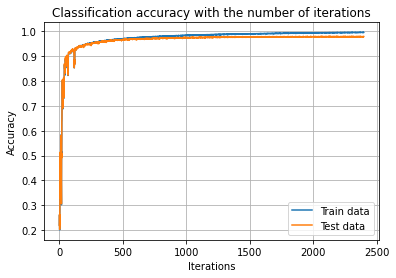

In [17]:
plt.title('Classification accuracy with the number of iterations')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.plot(score_train, label='Train data')
plt.plot(score_test, label='Test data')
plt.legend()
plt.grid()
plt.savefig('MLP_1.svg')

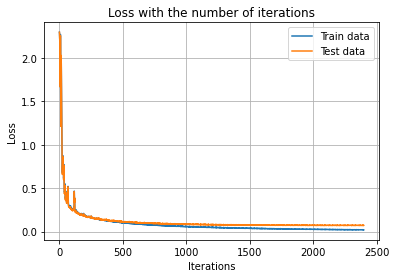

In [18]:
plt.title('Loss with the number of iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(loss_train, label='Train data')
plt.plot(loss_test, label='Test data')
plt.legend()
plt.grid()
plt.savefig('MLP_2.svg')